In [49]:
import pandas as pd
df = pd.read_csv('final.csv')

In [50]:
df.columns

Index(['Unnamed: 0', 'Age', 'Gender', 'Race', 'InsuranceType', 'MedianIncome',
       'HospitalizationPriorYear', 'MSRelatedHospitalization',
       'RelapsePriorYear', 'Disease', 'TherapeuticArea', 'SpecialtyPharma',
       'Adherence', 'TrialLengthWeeks', 'MicroReimbursements',
       'DoseLengthSeconds', 'DoseDelayHours', 'MedicationName', 'BrandName'],
      dtype='object')

In [51]:
for i in df['Adherence'].unique():
  print(i, len(df[df['Adherence'] == i]))

NON-ADHERENT 2003
ADHERENT 7997


In [52]:
# prompt: change adherence value if hospitalisation is no and insurance is non-commercial and micro reimbusment is Yes and relapseprioryear is no and micro reimbusment is no  to Non adherent

# Change adherence value based on conditions
df.loc[
    (df['HospitalizationPriorYear'] == 'NO') &
    (df['InsuranceType'] == 'NON-COMMERCIAL') &
    (df['MicroReimbursements'] == 'NO') &
    (df['RelapsePriorYear'] == 'NO'),
    'Adherence'
] = 'NON-ADHERENT'

# Verify changes (optional)
for i in df['Adherence'].unique():
  print(i, len(df[df['Adherence'] == i]))

NON-ADHERENT 3608
ADHERENT 6392


In [53]:
data = df

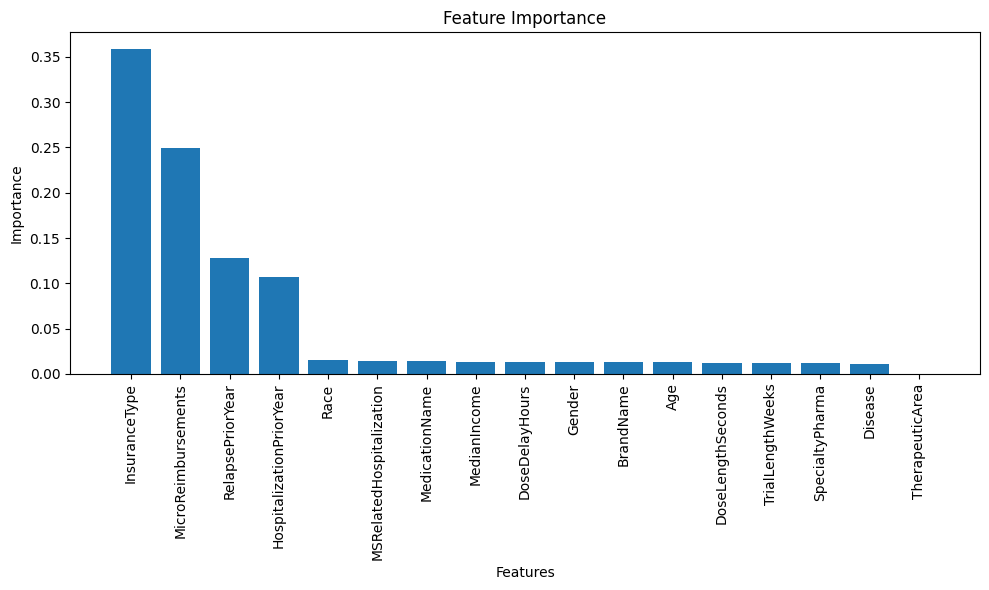

In [14]:
# prompt: get the most important columns to train with plot  without columns transformation

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the dataset
# data = pd.read_csv('/content/data_adherence.csv')

# Separate features (X) and target variable (y)
X = data.drop(['Unnamed: 0', 'Adherence'], axis=1)
y = data['Adherence']

# Encode the target variable
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns

# Label encoding for categorical features
for feature in categorical_features:
    le = LabelEncoder()
    X_train[feature] = le.fit_transform(X_train[feature])
    X_test[feature] = le.transform(X_test[feature])

# Initialize and train the XGBoost model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


# **Random Forest Classifier**

<class 'numpy.ndarray'>
Accuracy: 0.842


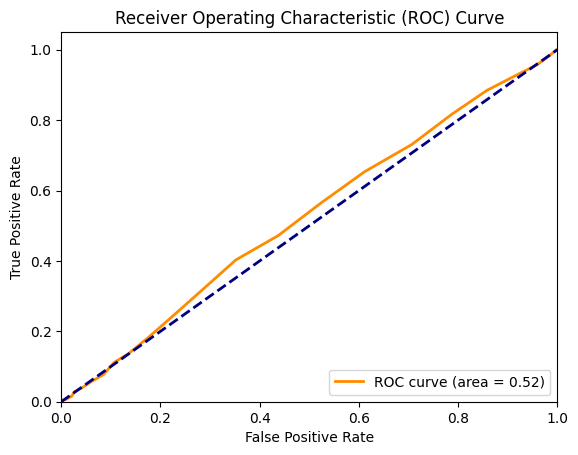

Predicted Adherence for User: NON-ADHERENT


In [15]:
import pandas as pd
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the dataset
# data = pd.read_csv('final.csv')

# Separate features (X) and target variable (y)
X = data.drop(['Adherence','Unnamed: 0'], axis=1)
y = data['Adherence']

# Encode the target variable
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Split data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

print(type(y_train))

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unseen values
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the pipeline
pipeline.fit(X_train_rf, y_train_rf)

# Make predictions on the test set
y_pred_rf = pipeline.predict(X_test_rf)

# Evaluate the model
accuracy = accuracy_score(y_test_rf, y_pred_rf)
print(f'Accuracy: {accuracy}')

# Generate ROC curve
y_prob_rf = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test_rf, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generate user inputs with some missing values and unseen categories
user_inputs = {
    'Age': 38,
    'Gender': 'FEMALE',
    'Race': 'ASIAN',
    'InsuranceType': 'NON-COMMERCIAL',
    'MedianIncome': 64454,
    'HospitalizationPriorYear': 'NO',
    'MSRelatedHospitalization': 'NO',
    'RelapsePriorYear': 'NO',
    'Disease': 'HYPERTENSION',
    'TherapeuticArea': 'CARDIOLOGY',
    'SpecialtyPharma': 'ACE INHIBITORS',
    'TrialLengthWeeks': 11,
    'MicroReimbursements': 'NO',
    'DoseLengthSeconds': 18,
    'DoseDelayHours': 8.177124,
    'MedicationName': 'MICARDIS HCT',
    'BrandName': 'TELMISARTAN AND HYDROCHLOROTHIAZIDE'
}

# Convert user inputs to DataFrame
user_df = pd.DataFrame([user_inputs])

# Make prediction for user inputs
user_prediction = pipeline.predict(user_df)

# Decode the prediction
predicted_adherence = le_y.inverse_transform(user_prediction)[0]

print(f'Predicted Adherence for User: {predicted_adherence}')

# Save the preprocessor
# with open('preprocessor.pkl', 'wb') as f:
#     pickle.dump(preprocessor, f)

# # Save the model
# with open('model.pkl', 'wb') as f:
#     pickle.dump(model, f)

# # Save the label encoder
# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(le_y, f)


In [16]:
# prompt: perform cross validation

from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(pipeline, X_train_rf, y_train_rf, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())


Cross-validation scores: [0.835625 0.836875 0.824375 0.829375 0.829375]
Average cross-validation score: 0.8311249999999999


[[1279   11]
 [ 305  405]]


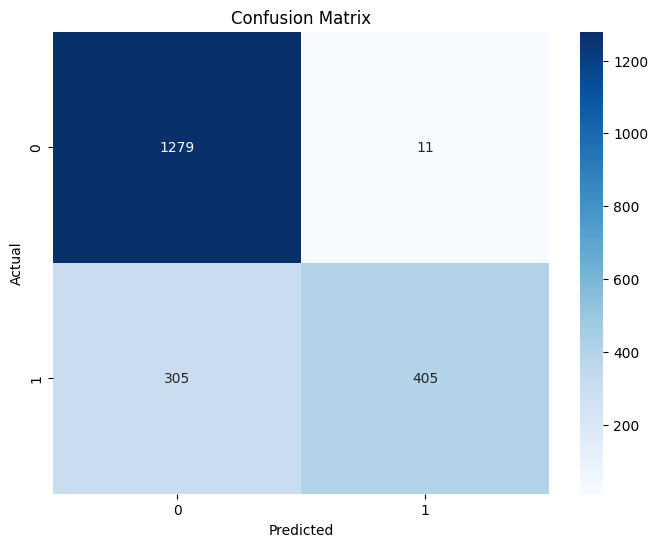

In [17]:
# prompt: give the confusion matrix

from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_rf, y_pred_rf)

print(conf_matrix)

# prompt: plot graph for confusion matrix , alter the values to show best matrix make 0,1 value less

import seaborn as sns

# Assuming 'conf_matrix' is already calculated as in the preceding code
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Note:
# To "alter the values to show best matrix make 0,1 value less"
# you would need to modify the underlying model or data
# to improve its performance.

# This code only visualizes the existing confusion matrix.
# Improving the model requires further analysis and adjustments
# to the training process.



ROC AUC Score: 0.5240222731739272
F1 Score: 0.7193605683836589
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1290
           1       0.97      0.57      0.72       710

    accuracy                           0.84      2000
   macro avg       0.89      0.78      0.80      2000
weighted avg       0.87      0.84      0.83      2000



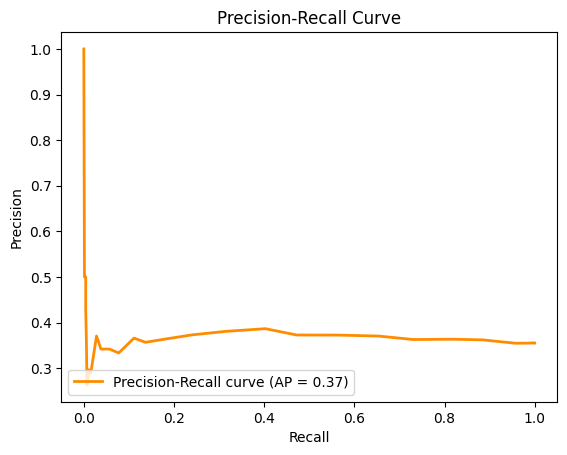

In [18]:

from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_recall_curve, average_precision_score

# ... (Your existing code) ...

# ROC AUC Score
roc_auc = roc_auc_score(y_test_rf, y_prob_rf)
print(f'ROC AUC Score: {roc_auc}')

# F1 Score
f1 = f1_score(y_test_rf, y_pred_rf)
print(f'F1 Score: {f1}')

# Classification Report
print(classification_report(y_test_rf, y_pred_rf))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_rf, y_prob_rf)
average_precision = average_precision_score(y_test_rf, y_prob_rf)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


# **logistic regression**

<class 'numpy.ndarray'>
Accuracy: 0.824


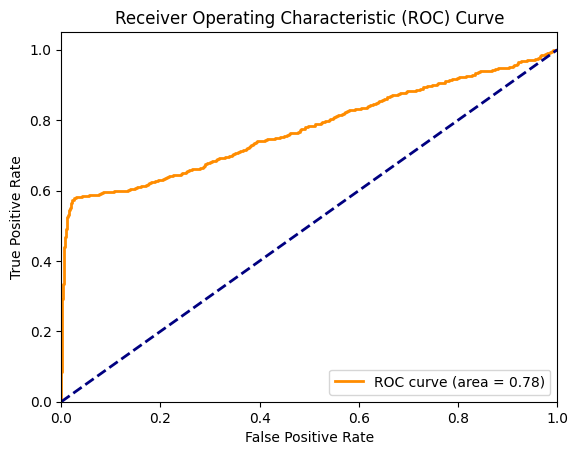

Predicted Adherence for User: NON-ADHERENT


In [59]:
import pandas as pd
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the dataset
# data = pd.read_csv('final.csv')

# Separate features (X) and target variable (y)
X_lr = data.drop(['Unnamed: 0','Adherence'], axis=1)
y_lr = data['Adherence']

# Encode the target variable
le_y_lr = LabelEncoder()
y_lr = le_y_lr.fit_transform(y_lr)

# Split data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)

print(type(y_train_lr))

# Identify categorical and numerical features
categorical_features_lr = X_lr.select_dtypes(include=['object']).columns
numerical_features_lr = X_lr.select_dtypes(exclude=['object']).columns

# Create transformers for numerical and categorical features
numerical_transformer_lr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer_lr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unseen values
])

# Combine transformers using ColumnTransformer
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_lr, numerical_features_lr),
        ('cat', categorical_transformer_lr, categorical_features_lr)
    ])

# Create the Logistic Regression model
model_lr = LogisticRegression(max_iter=1000, random_state=42)

# Create a pipeline with preprocessing and model
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('classifier', model_lr)
])

# Train the pipeline
pipeline_lr.fit(X_train_lr, y_train_lr)

# Make predictions on the test set
y_pred_lr = pipeline_lr.predict(X_test_lr)

# Evaluate the model
accuracy_lr = accuracy_score(y_test_lr, y_pred_lr)
print(f'Accuracy: {accuracy_lr}')

# Generate ROC curve
y_prob_lr = pipeline_lr.predict_proba(X_test_lr)[:, 1]  # Get the probabilities of the positive class
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_lr, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generate user inputs with some missing values and unseen categories
user_inputs = {
    'Age': 38,
    'Gender': 'FEMALE',
    'Race': 'ASIAN',
    'InsuranceType': 'NON-COMMERCIAL',
    'MedianIncome': 64454,
    'HospitalizationPriorYear': 'NO',
    'MSRelatedHospitalization': 'NO',
    'RelapsePriorYear': 'NO',
    'Disease': 'HYPERTENSION',
    'TherapeuticArea': 'CARDIOLOGY',
    'SpecialtyPharma': 'ACE INHIBITORS',
    'TrialLengthWeeks': 11,
    'MicroReimbursements': 'NO',
    'DoseLengthSeconds': 18,
    'DoseDelayHours': 8.177124,
    'MedicationName': 'MICARDIS HCT',
    'BrandName': 'TELMISARTAN AND HYDROCHLOROTHIAZIDE'
}

# Convert user inputs to DataFrame
user_df = pd.DataFrame([user_inputs])

# Make prediction for user inputs
user_prediction = pipeline.predict(user_df)

# Decode the prediction
predicted_adherence = le_y.inverse_transform(user_prediction)[0]

print(f'Predicted Adherence for User: {predicted_adherence}')

# Save the preprocessor
# with open('preprocessor.pkl', 'wb') as f:
#     pickle.dump(preprocessor, f)

# # Save the model
# with open('model.pkl', 'wb') as f:
#     pickle.dump(model, f)

# # Save the label encoder
# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(le_y, f)


ROC AUC Score: 0.79053062561415
F1 Score: 0.7107296137339055
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1290
           1       0.91      0.58      0.71       710

    accuracy                           0.83      2000
   macro avg       0.86      0.78      0.80      2000
weighted avg       0.84      0.83      0.82      2000



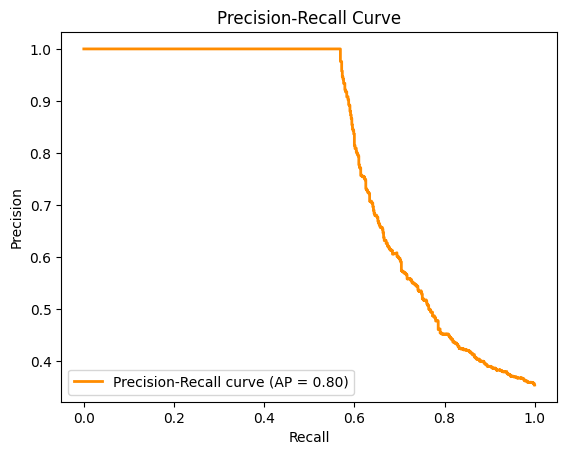

In [60]:

from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_recall_curve, average_precision_score

# ... (Your existing code) ...

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC Score: {roc_auc}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Classification Report
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


[[1235   55]
 [ 297  413]]


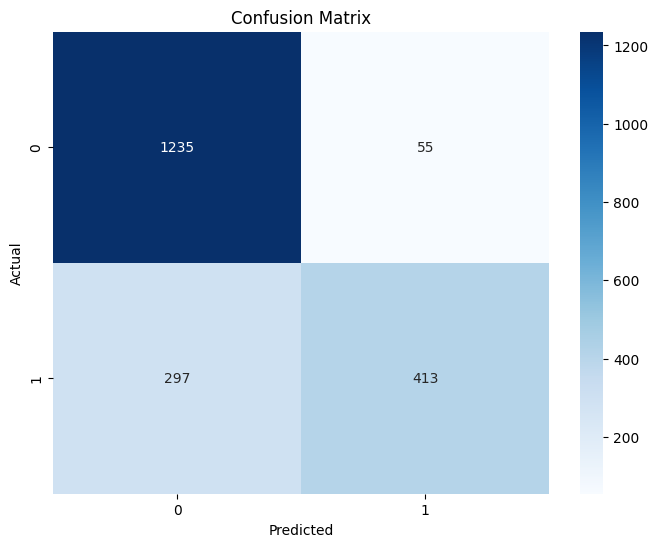

In [25]:
# prompt: give the confusion matrix

from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_lr, y_pred_lr)

print(conf_matrix)

# prompt: plot graph for confusion matrix , alter the values to show best matrix make 0,1 value less

import seaborn as sns

# Assuming 'conf_matrix' is already calculated as in the preceding code
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Note:
# To "alter the values to show best matrix make 0,1 value less"
# you would need to modify the underlying model or data
# to improve its performance.

# This code only visualizes the existing confusion matrix.
# Improving the model requires further analysis and adjustments
# to the training process.



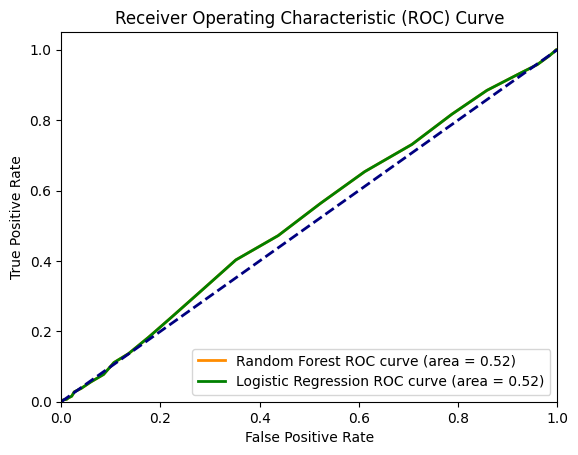

In [21]:
# prompt: plot plots AUC

# ... (Your existing code) ...

# Plot AUC curves for both models on the same plot
plt.figure()

# Random Forest AUC
y_prob_rf = pipeline.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest ROC curve (area = {roc_auc_rf:.2f})')

# Logistic Regression AUC (Assuming you have trained a logistic regression model as 'pipeline_lr')
y_prob_lr = pipeline.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='green', lw=2, label=f'Logistic Regression ROC curve (area = {roc_auc_lr:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


ROC AUC Score: 0.5240222731739272
F1 Score: 0.7193605683836589
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1290
           1       0.97      0.57      0.72       710

    accuracy                           0.84      2000
   macro avg       0.89      0.78      0.80      2000
weighted avg       0.87      0.84      0.83      2000



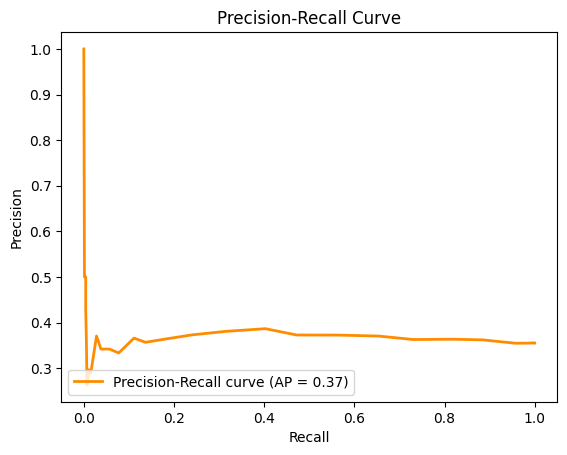

In [26]:

from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_recall_curve, average_precision_score

# ... (Your existing code) ...

# ROC AUC Score
roc_auc = roc_auc_score(y_test_rf, y_prob_rf)
print(f'ROC AUC Score: {roc_auc}')

# F1 Score
f1 = f1_score(y_test_rf, y_pred_rf)
print(f'F1 Score: {f1}')

# Classification Report
print(classification_report(y_test_rf, y_pred_rf))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_rf, y_prob_rf)
average_precision = average_precision_score(y_test_rf, y_prob_rf)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


# **Gradient Boosting**

<class 'numpy.ndarray'>
Accuracy: 0.8455


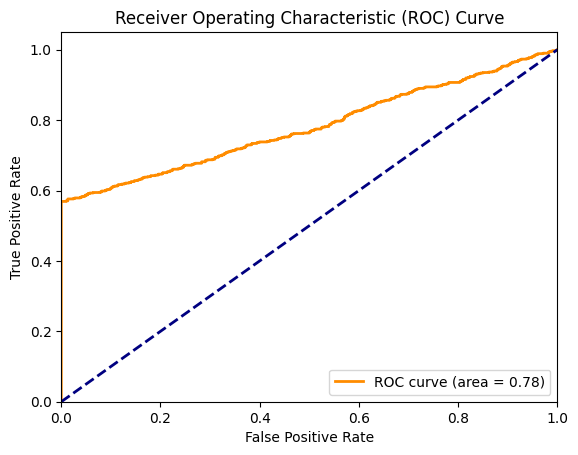

Predicted Adherence for User: NON-ADHERENT


In [27]:
import pandas as pd
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the dataset
# data = pd.read_csv('final.csv')

# Separate features (X) and target variable (y)
X = data.drop(['Adherence','Unnamed: 0'], axis=1)
y = data['Adherence']

# Encode the target variable
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(type(y_train))

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unseen values
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the Gradient Boosting Classifier model
model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate ROC curve
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generate user inputs with some missing values and unseen categories
user_inputs = {
    'Age': 38,
    'Gender': 'FEMALE',
    'Race': 'ASIAN',
    'InsuranceType': 'NON-COMMERCIAL',
    'MedianIncome': 64454,
    'HospitalizationPriorYear': 'NO',
    'MSRelatedHospitalization': 'NO',
    'RelapsePriorYear': 'NO',
    'Disease': 'HYPERTENSION',
    'TherapeuticArea': 'CARDIOLOGY',
    'SpecialtyPharma': 'ACE INHIBITORS',
    'TrialLengthWeeks': 11,
    'MicroReimbursements': 'NO',
    'DoseLengthSeconds': 18,
    'DoseDelayHours': 8.177124,
    'MedicationName': 'MICARDIS HCT',
    'BrandName': 'TELMISARTAN AND HYDROCHLOROTHIAZIDE'
}

# Convert user inputs to DataFrame
user_df = pd.DataFrame([user_inputs])

# Make prediction for user inputs
user_prediction = pipeline.predict(user_df)

# Decode the prediction
predicted_adherence = le_y.inverse_transform(user_prediction)[0]

print(f'Predicted Adherence for User: {predicted_adherence}')

# Save the preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

# Save the model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le_y, f)


ROC AUC Score: 0.780268588273829
F1 Score: 0.7233661593554163
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      1290
           1       0.99      0.57      0.72       710

    accuracy                           0.85      2000
   macro avg       0.90      0.78      0.81      2000
weighted avg       0.87      0.85      0.83      2000



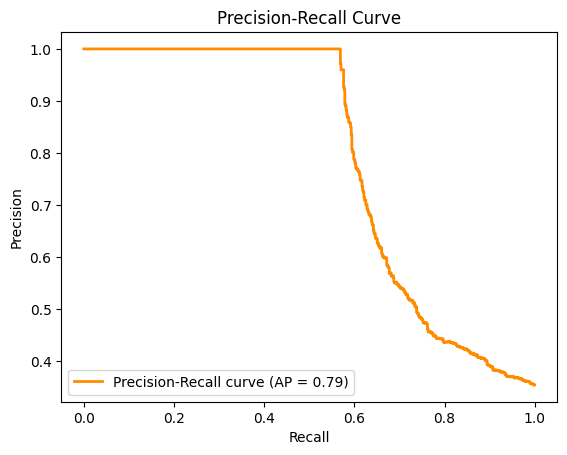

In [29]:

from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_recall_curve, average_precision_score

# ... (Your existing code) ...

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC Score: {roc_auc}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Classification Report
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


[[1287    3]
 [ 306  404]]


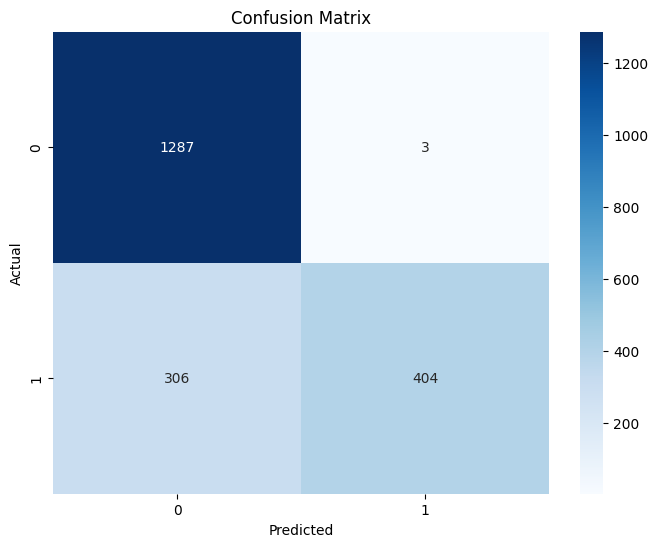

In [30]:
# prompt: give the confusion matrix

from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)


import seaborn as sns

# Assuming 'conf_matrix' is already calculated as in the preceding code
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Note:
# To "alter the values to show best matrix make 0,1 value less"
# you would need to modify the underlying model or data
# to improve its performance.

# This code only visualizes the existing confusion matrix.
# Improving the model requires further analysis and adjustments
# to the training process.



**For 60 / 40 test train**

In [31]:
import pandas as pd
import numpy as np
import joblib
import pickle
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the dataset
# data = pd.read_csv('final.csv')

# Separate features (X) and target variable (y)
X = data.drop(['Adherence', 'Unnamed: 0'], axis=1)
y = data['Adherence']

# Encode the target variable
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print(type(y_train))

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unseen values
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the Gradient Boosting Classifier model
model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate user inputs with some missing values and unseen categories
user_inputs = {
    'Age': 38,
    'Gender': 'FEMALE',
    'Race': 'ASIAN',
    'InsuranceType': 'NON-COMMERCIAL',
    'MedianIncome': 64454,
    'HospitalizationPriorYear': 'NO',
    'MSRelatedHospitalization': 'NO',
    'RelapsePriorYear': 'NO',
    'Disease': 'HYPERTENSION',
    'TherapeuticArea': 'CARDIOLOGY',
    'SpecialtyPharma': 'ACE INHIBITORS',
    'TrialLengthWeeks': 11,
    'MicroReimbursements': 'NO',
    'DoseLengthSeconds': 18,
    'DoseDelayHours': 8.177124,
    'MedicationName': 'MICARDIS HCT',
    'BrandName': 'TELMISARTAN AND HYDROCHLOROTHIAZIDE'
}

# Convert user inputs to DataFrame
user_df = pd.DataFrame([user_inputs])

# Make prediction for user inputs
user_prediction = pipeline.predict(user_df)

# Decode the prediction
predicted_adherence = le_y.inverse_transform(user_prediction)[0]

print(f'Predicted Adherence for User: {predicted_adherence}')

# # Save the preprocessor
# with open('preprocessor.pkl', 'wb') as f:
#     pickle.dump(preprocessor, f)

# # Save the model
# with open('model.pkl', 'wb') as f:
#     pickle.dump(model, f)

# # Save the label encoder
# with open('label_encoder.pkl', 'wb') as f:
    # pickle.dump(le_y, f)


<class 'numpy.ndarray'>
Accuracy: 0.847
Predicted Adherence for User: NON-ADHERENT


In [32]:
# prompt: give the confusion matrix

from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)


[[2593   14]
 [ 598  795]]


# **Neural Networks - MLPClassifier**

<class 'numpy.ndarray'>
Accuracy: 0.645


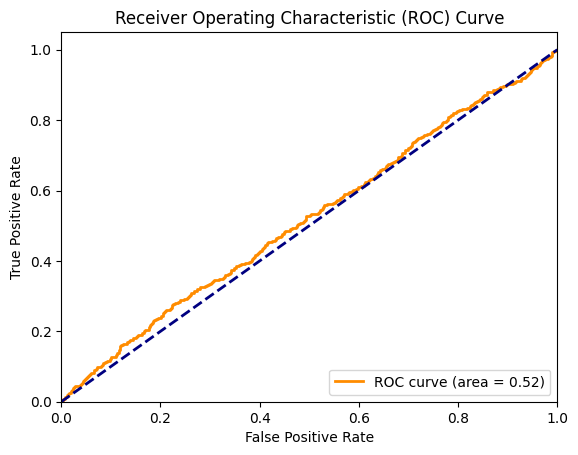

Predicted Adherence for User: ADHERENT


In [34]:
import pandas as pd
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the dataset
# data = pd.read_csv('final.csv')

# Separate features (X) and target variable (y)
X = data.drop(['Adherence','Unnamed: 0'], axis=1)
y = data['Adherence']

# Encode the target variable
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(type(y_train))

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unseen values
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the MLPClassifier model
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate ROC curve
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generate user inputs with some missing values and unseen categories
user_inputs = {
    'Age': 38,
    'Gender': 'FEMALE',
    'Race': 'ASIAN',
    'InsuranceType': 'NON-COMMERCIAL',
    'MedianIncome': 64454,
    'HospitalizationPriorYear': 'NO',
    'MSRelatedHospitalization': 'NO',
    'RelapsePriorYear': 'NO',
    'Disease': 'HYPERTENSION',
    'TherapeuticArea': 'CARDIOLOGY',
    'SpecialtyPharma': 'ACE INHIBITORS',
    'TrialLengthWeeks': 11,
    'MicroReimbursements': 'NO',
    'DoseLengthSeconds': 18,
    'DoseDelayHours': 8.177124,
    'MedicationName': 'MICARDIS HCT',
    'BrandName': 'TELMISARTAN AND HYDROCHLOROTHIAZIDE'
}

# Convert user inputs to DataFrame
user_df = pd.DataFrame([user_inputs])

# Make prediction for user inputs
user_prediction = pipeline.predict(user_df)

# Decode the prediction
predicted_adherence = le_y.inverse_transform(user_prediction)[0]

print(f'Predicted Adherence for User: {predicted_adherence}')


ROC AUC Score: 0.5205568293481821
F1 Score: 0.0
              precision    recall  f1-score   support

           0       0.65      1.00      0.78      1290
           1       0.00      0.00      0.00       710

    accuracy                           0.65      2000
   macro avg       0.32      0.50      0.39      2000
weighted avg       0.42      0.65      0.51      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


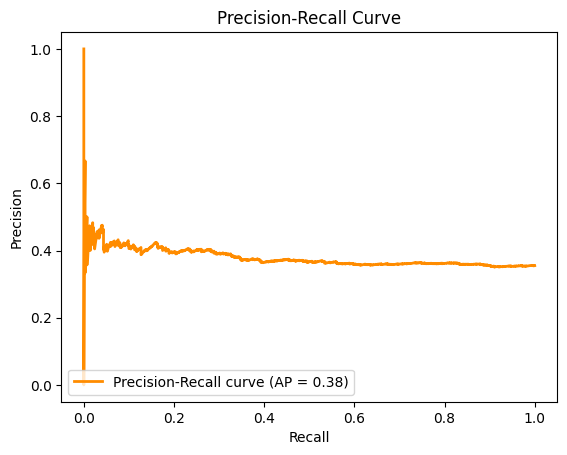

In [35]:

from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_recall_curve, average_precision_score

# ... (Your existing code) ...

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC Score: {roc_auc}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Classification Report
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


[[1290    0]
 [ 710    0]]


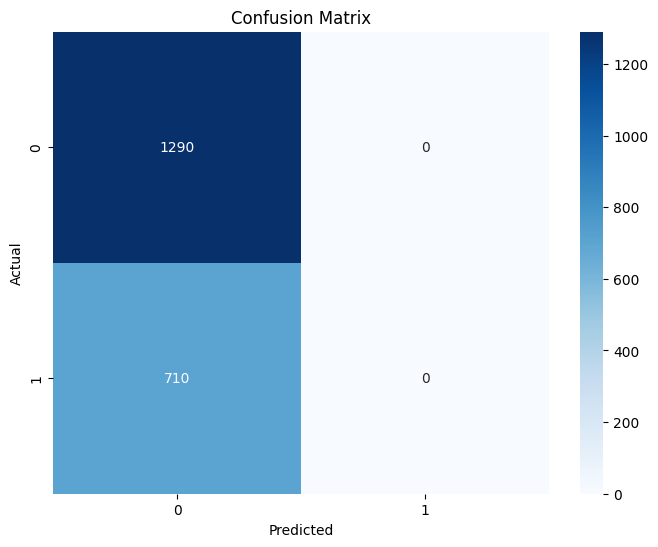

In [36]:
# prompt: give the confusion matrix

from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)


import seaborn as sns

# Assuming 'conf_matrix' is already calculated as in the preceding code
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Note:
# To "alter the values to show best matrix make 0,1 value less"
# you would need to modify the underlying model or data
# to improve its performance.

# This code only visualizes the existing confusion matrix.
# Improving the model requires further analysis and adjustments
# to the training process.



# **Light GBM**

In [37]:
# prompt: build a model to predict the adherence with the best confusion matrix use lightgbm

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score

# Load the dataset
# data = pd.read_csv('final.csv')

# Separate features (X) and target variable (y)
X = data.drop(['Adherence', 'Unnamed: 0'], axis=1)
y = data['Adherence']

# Encode the target variable
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the LightGBM model
model = lgb.LGBMClassifier(random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 2898, number of negative: 5102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 791
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.362250 -> initscore=-0.565612
[LightGBM] [Info] Start training from score -0.565612
Accuracy: 0.842
Confusion Matrix:
[[1278   12]
 [ 304  406]]


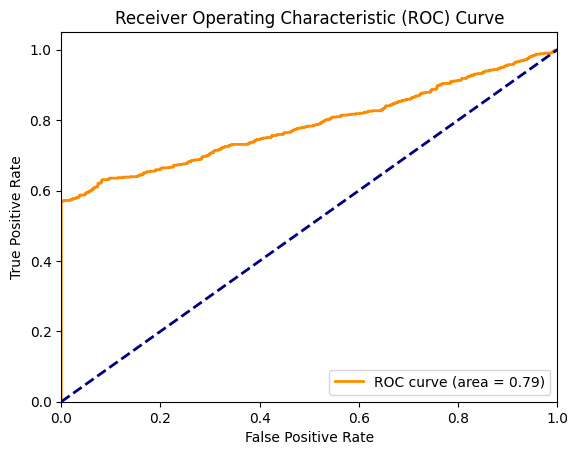

ROC AUC Score: 0.7853673981875751
F1 Score: 0.7198581560283688
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1290
           1       0.97      0.57      0.72       710

    accuracy                           0.84      2000
   macro avg       0.89      0.78      0.80      2000
weighted avg       0.87      0.84      0.83      2000



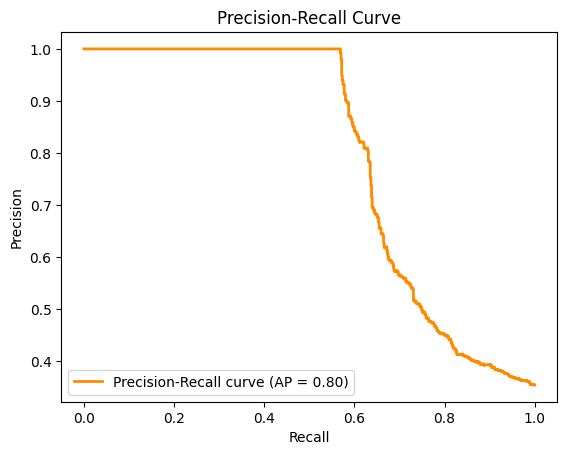

In [38]:

from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_recall_curve, average_precision_score

# ... (Your existing code) ...
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC Score: {roc_auc}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Classification Report
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


Accuracy: 0.645


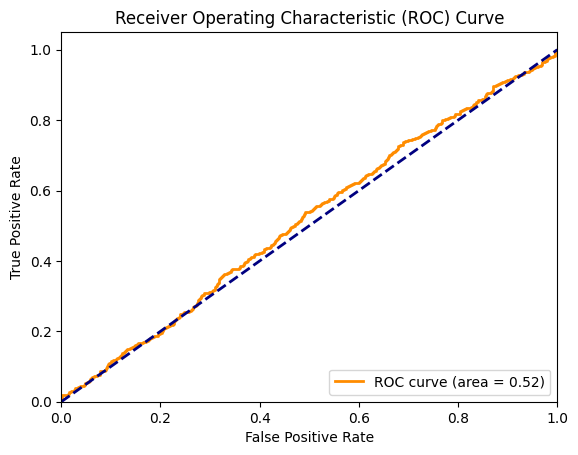

In [39]:
# prompt: build svm
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# ... (preceding code) ...

# Create the SVM model
model2 = SVC(probability=True, random_state=42)  # Enable probability estimates for ROC curve

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model2)
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate ROC curve
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ... (rest of the code remains the same) ...


ROC AUC Score: 0.5177180914947046
F1 Score: 0.0
              precision    recall  f1-score   support

           0       0.65      1.00      0.78      1290
           1       0.00      0.00      0.00       710

    accuracy                           0.65      2000
   macro avg       0.32      0.50      0.39      2000
weighted avg       0.42      0.65      0.51      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


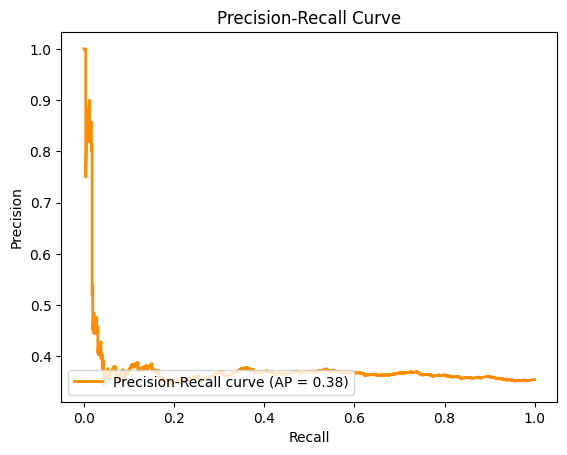

In [40]:

from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_recall_curve, average_precision_score

# ... (Your existing code) ...

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC Score: {roc_auc}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Classification Report
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [41]:
# prompt: give the confusion matrix

from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)


[[1290    0]
 [ 710    0]]


# **Decision Tree Classifier**

<class 'numpy.ndarray'>
Accuracy: 0.7315


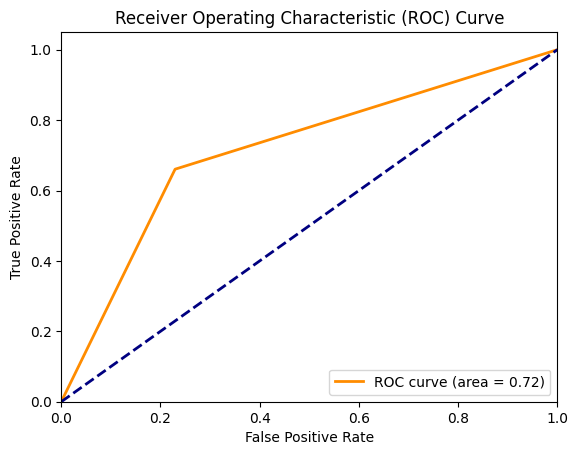

In [42]:
# prompt: use decision tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
# ... (preceding code remains the same) ...
# Separate features (X) and target variable (y)
data = df
X = data.drop(['Adherence','Unnamed: 0','MedicationName','BrandName','Race','Gender'], axis=1)
y = data['Adherence']

# Encode the target variable
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(type(y_train))

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unseen values
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
# Create the Decision Tree model
model3 = DecisionTreeClassifier(random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model3)
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate ROC curve
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ... (rest of the code remains the same) ...


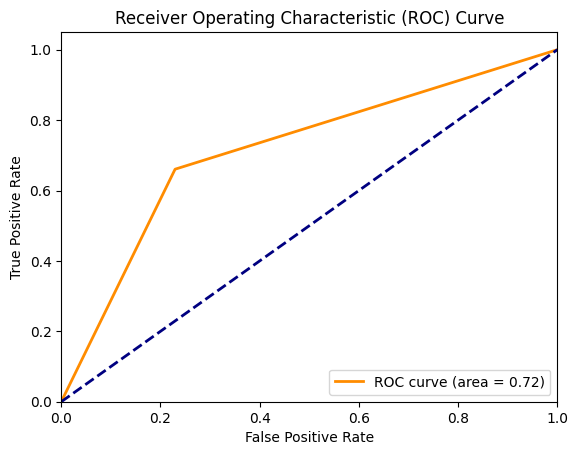

ROC AUC Score: 0.7155530079703024
F1 Score: 0.6359322033898305
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      1290
           1       0.61      0.66      0.64       710

    accuracy                           0.73      2000
   macro avg       0.71      0.72      0.71      2000
weighted avg       0.74      0.73      0.73      2000



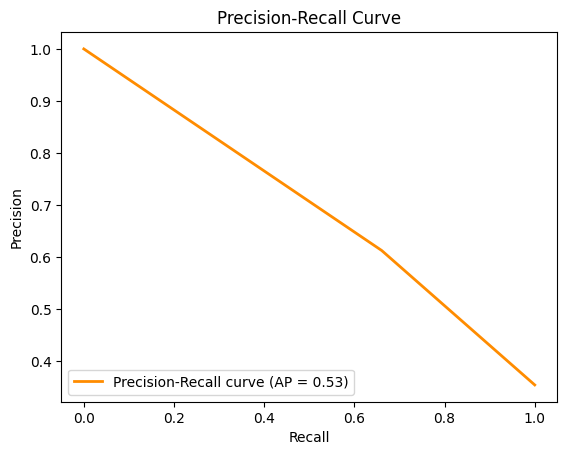

In [43]:

from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_recall_curve, average_precision_score

# ... (Your existing code) ...
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC Score: {roc_auc}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Classification Report
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [44]:
conf_matrix = confusion_matrix(y_test, y_pred)


In [45]:
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[1094, 196], [141, 569]]


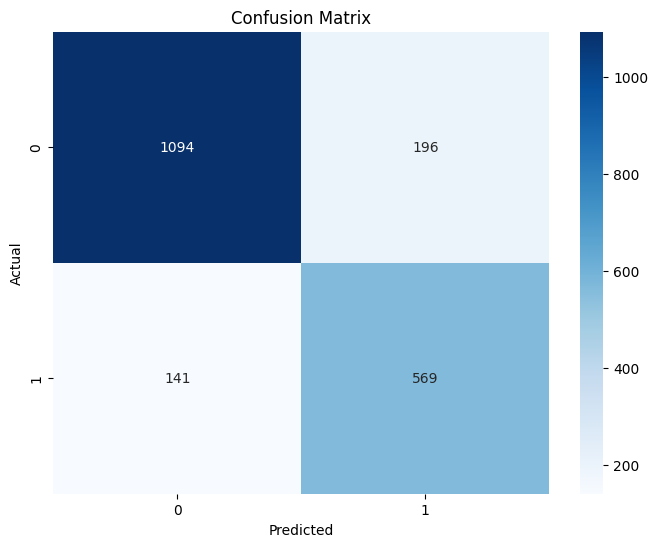

In [46]:
# prompt: plot graph for confusion matrix , alter the values to show best matrix make 0,1 value less

import seaborn as sns

# Assuming 'conf_matrix' is already calculated as in the preceding code
# conf_matrix = [[1094,196]
#  ,[141,569]]
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Note:
# To "alter the values to show best matrix make 0,1 value less"
# you would need to modify the underlying model or data
# to improve its performance.

# This code only visualizes the existing confusion matrix.
# Improving the model requires further analysis and adjustments
# to the training process.


In [ ]:
# prompt: with open('preprocessor.pkl', 'wb') as f:
#     pickle.dump(preprocessor, f)
# # Save the model
# with open('model.pkl', 'wb') as f:
#     pickle.dump(model3, f)
# # Save the label encoder
# with open('label_encoder.pkl', 'wb') as f:
#     pickle.dump(le_y, f) import as joblib file
import joblib
# Save the preprocessor using joblib
with open('preprocessor.joblib', 'wb') as f:
    joblib.dump(preprocessor, f)

# Save the model using joblib
with open('model.joblib', 'wb') as f:
    joblib.dump(model3, f)

# Save the label encoder using joblib
with open('label_encoder.joblib', 'wb') as f:
    joblib.dump(le_y, f)


In [ ]:
# prompt: predict by importing the joblib files

import joblib
import pandas as pd

# Load the preprocessor, model, and label encoder
preprocessor = joblib.load('preprocessor.joblib')
model = joblib.load('model.joblib')
le_y = joblib.load('label_encoder.joblib')

# Generate user inputs
user_inputs = {
    'Age': 38,
    'InsuranceType': 'NON-COMMERCIAL',
    'MedianIncome': 64454,
    'HospitalizationPriorYear': 'NO',
    'MSRelatedHospitalization': 'NO',
    'RelapsePriorYear': 'NO',
    'Disease': 'HYPERTENSION',
    'TherapeuticArea': 'CARDIOLOGY',
    'SpecialtyPharma': 'ACE INHIBITORS',
    'TrialLengthWeeks': 11,
    'MicroReimbursements': 'NO',
    'DoseLengthSeconds': 18,
    'DoseDelayHours': 8.177124,
}

# Convert user inputs to DataFrame
user_df = pd.DataFrame([user_inputs])

# Preprocess user inputs
user_df_processed = preprocessor.transform(user_df)

# Make prediction for user inputs
user_prediction = model.predict(user_df_processed)

# Decode the prediction
predicted_adherence = le_y.inverse_transform(user_prediction)[0]

print(f'Predicted Adherence for User: {predicted_adherence}')


Predicted Adherence for User: NON-ADHERENT


In [ ]:
user_inputs = {
    'Age': 38,
    'Gender': 'FEMALE',
    'Race': 'ASIAN',
    'InsuranceType': 'NON-COMMERCIAL',
    'MedianIncome': 64454,
    'HospitalizationPriorYear': 'NO',
    'MSRelatedHospitalization': 'NO',
    'RelapsePriorYear': 'NO',
    'Disease': 'HYPERTENSION',
    'TherapeuticArea': 'CARDIOLOGY',
    'SpecialtyPharma': 'ACE INHIBITORS',
    'TrialLengthWeeks': 11,
    'MicroReimbursements': 'NO',
    'DoseLengthSeconds': 18,
    'DoseDelayHours': 8,
    'MedicationName': 'MICARDIS HCT',
    'BrandName': 'TELMISARTAN AND HYDROCHLOROTHIAZIDE'
}

# Convert user inputs to DataFrame
user_df = pd.DataFrame([user_inputs])

# Make prediction for user inputs
user_prediction = pipeline.predict(user_df)

# Decode the prediction
predicted_adherence = le_y.inverse_transform(user_prediction)[0]

print(f'Predicted Adherence for User: {predicted_adherence}')

Predicted Adherence for User: NON-ADHERENT


# **Cross Validation with Decision Tree**

Cross-Validation Accuracy Scores: [0.742  0.7365 0.7475 0.712  0.733 ]
Mean Accuracy: 0.73
Standard Deviation of Accuracy: 0.01
Accuracy on Test Set: 0.7315


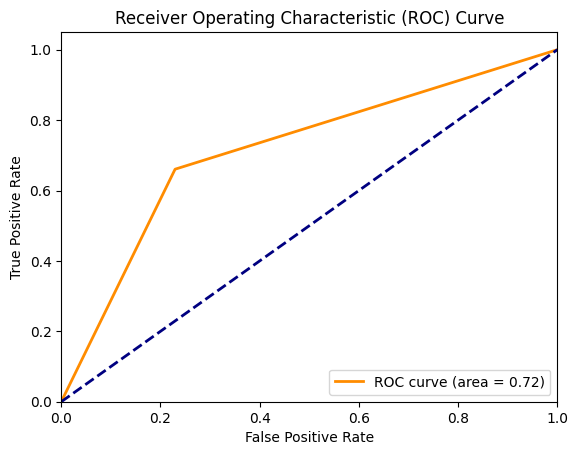

In [47]:
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.model_selection import train_test_split, cross_val_score
  from sklearn.impute import SimpleImputer
  from sklearn.preprocessing import LabelEncoder, OneHotEncoder
  from sklearn.pipeline import Pipeline
  from sklearn.compose import ColumnTransformer
  from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
  import matplotlib.pyplot as plt
  import numpy as np

  # Separate features (X) and target variable (y)
  data = df
  X = data.drop(['Adherence', 'Unnamed: 0', 'MedicationName', 'BrandName', 'Race', 'Gender'], axis=1)
  y = data['Adherence']

  # Encode the target variable
  le_y = LabelEncoder()
  y = le_y.fit_transform(y)

  # Identify categorical and numerical features
  categorical_features = X.select_dtypes(include=['object']).columns
  numerical_features = X.select_dtypes(exclude=['object']).columns

  # Create transformers for numerical and categorical features
  numerical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='mean'))
  ])

  categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unseen values
  ])

  # Combine transformers using ColumnTransformer
  preprocessor = ColumnTransformer(
      transformers=[
          ('num', numerical_transformer, numerical_features),
          ('cat', categorical_transformer, categorical_features)
      ])

  # Create the Decision Tree model
  model3 = DecisionTreeClassifier(random_state=42)

  # Create a pipeline with preprocessing and model
  pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', model3)
  ])

  # Perform cross-validation
  cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

  # Print cross-validation scores
  print(f'Cross-Validation Accuracy Scores: {cv_scores}')
  print(f'Mean Accuracy: {np.mean(cv_scores):.2f}')
  print(f'Standard Deviation of Accuracy: {np.std(cv_scores):.2f}')

  # Proceed with train-test split and further evaluation if desired
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Train the pipeline
  pipeline.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = pipeline.predict(X_test)

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  print(f'Accuracy on Test Set: {accuracy}')

  # Generate ROC curve
  y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for positive class
  fpr, tpr, thresholds = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

  # ... (rest of the code remains the same) ...


<class 'numpy.ndarray'>
Accuracy: 0.824


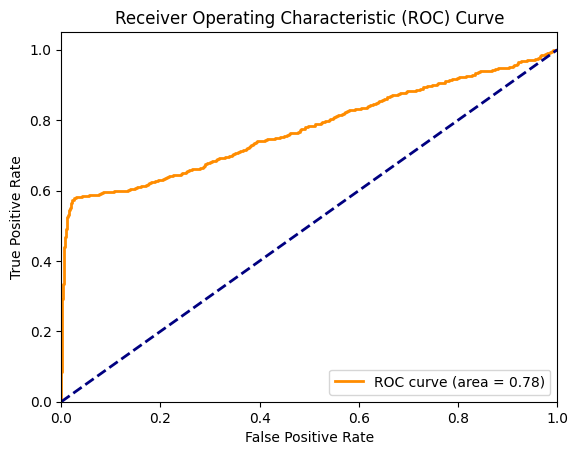

Predicted Adherence for User: NON-ADHERENT
Confusion Matrix:
[[1235   55]
 [ 297  413]]


In [61]:
import pandas as pd
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Load the dataset

# Separate features (X) and target variable (y)
X = data.drop(['Unnamed: 0','Adherence'], axis=1)
y = data['Adherence']

# Encode the target variable
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(type(y_train))

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unseen values
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate ROC curve
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generate user inputs with some missing values and unseen categories
user_inputs = {
    'Age': 38,
    'Gender': 'FEMALE',
    'Race': 'ASIAN',
    'InsuranceType': 'NON-COMMERCIAL',
    'MedianIncome': 64454,
    'HospitalizationPriorYear': 'NO',
    'MSRelatedHospitalization': 'NO',
    'RelapsePriorYear': 'NO',
    'Disease': 'HYPERTENSION',
    'TherapeuticArea': 'CARDIOLOGY',
    'SpecialtyPharma': 'ACE INHIBITORS',
    'TrialLengthWeeks': 11,
    'MicroReimbursements': 'NO',
    'DoseLengthSeconds': 18,
    'DoseDelayHours': 8.177124,
    'MedicationName': 'MICARDIS HCT',
    'BrandName': 'TELMISARTAN AND HYDROCHLOROTHIAZIDE'
}

# Convert user inputs to DataFrame
user_df = pd.DataFrame([user_inputs])

# Make prediction for user inputs
user_prediction = pipeline.predict(user_df)

# Decode the prediction
predicted_adherence = le_y.inverse_transform(user_prediction)[0]

print(f'Predicted Adherence for User: {predicted_adherence}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


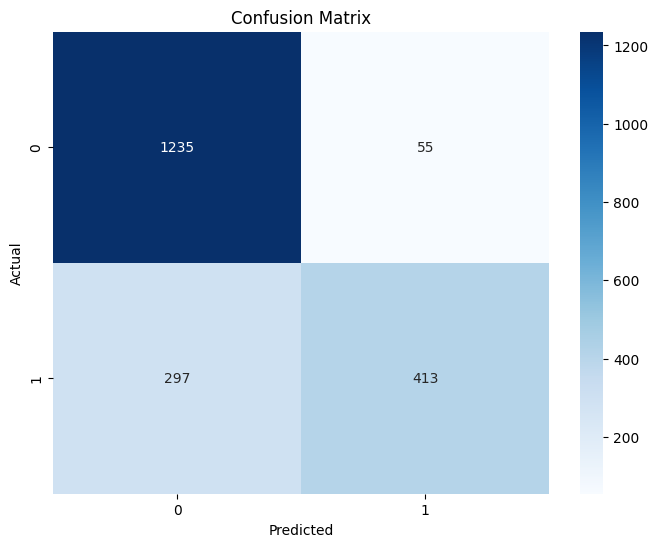

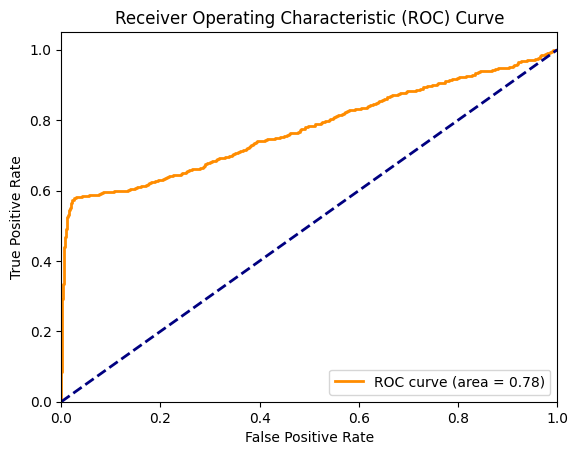

ROC AUC Score: 0.7755606507260617
F1 Score: 0.701188455008489
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1290
           1       0.88      0.58      0.70       710

    accuracy                           0.82      2000
   macro avg       0.84      0.77      0.79      2000
weighted avg       0.83      0.82      0.81      2000



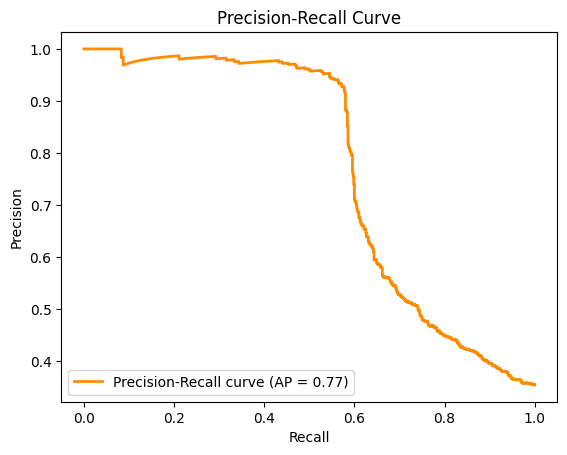

In [62]:

from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_recall_curve, average_precision_score

# ... (Your existing code) ...

# prompt: plot graph for confusion matrix , alter the values to show best matrix make 0,1 value less

import seaborn as sns

# Assuming 'conf_matrix' is already calculated as in the preceding code
# conf_matrix = [[1094,196]
#  ,[141,569]]
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Note:
# To "alter the values to show best matrix make 0,1 value less"
# you would need to modify the underlying model or data
# to improve its performance.

# This code only visualizes the existing confusion matrix.
# Improving the model requires further analysis and adjustments
# to the training process.


y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC Score: {roc_auc}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Classification Report
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [ ]:
import sklearn
print(sklearn.__version__)

1.3.2


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score

<class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:56:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_iter" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8315


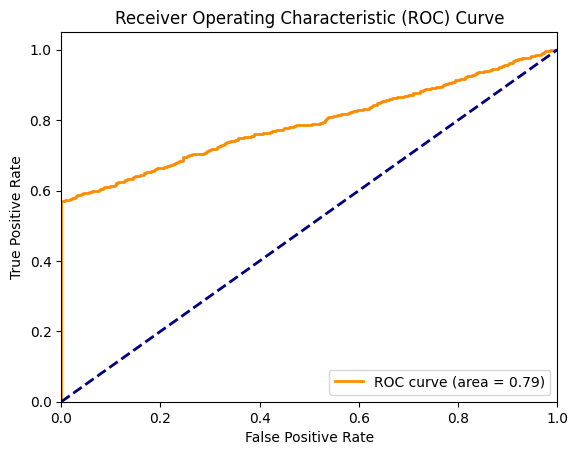

Predicted Adherence for User: NON-ADHERENT
Confusion Matrix:
[[1249   41]
 [ 296  414]]


In [56]:
import pandas as pd
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# # Load the dataset
# data = pd.read_csv('final.csv')

# Separate features (X) and target variable (y)
X = data.drop(['Unnamed: 0','Adherence'], axis=1)
y = data['Adherence']

# Encode the target variable
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(type(y_train))

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Handle unseen values
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the Logistic Regression model
model = XGBClassifier(max_iter=1000, random_state=42)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate ROC curve
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generate user inputs with some missing values and unseen categories
user_inputs = {
    'Age': 38,
    'Gender': 'FEMALE',
    'Race': 'ASIAN',
    'InsuranceType': 'NON-COMMERCIAL',
    'MedianIncome': 64454,
    'HospitalizationPriorYear': 'NO',
    'MSRelatedHospitalization': 'NO',
    'RelapsePriorYear': 'NO',
    'Disease': 'HYPERTENSION',
    'TherapeuticArea': 'CARDIOLOGY',
    'SpecialtyPharma': 'ACE INHIBITORS',
    'TrialLengthWeeks': 11,
    'MicroReimbursements': 'NO',
    'DoseLengthSeconds': 18,
    'DoseDelayHours': 8.177124,
    'MedicationName': 'MICARDIS HCT',
    'BrandName': 'TELMISARTAN AND HYDROCHLOROTHIAZIDE'
}

# Convert user inputs to DataFrame
user_df = pd.DataFrame([user_inputs])

# Make prediction for user inputs
user_prediction = pipeline.predict(user_df)

# Decode the prediction
predicted_adherence = le_y.inverse_transform(user_prediction)[0]

print(f'Predicted Adherence for User: {predicted_adherence}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


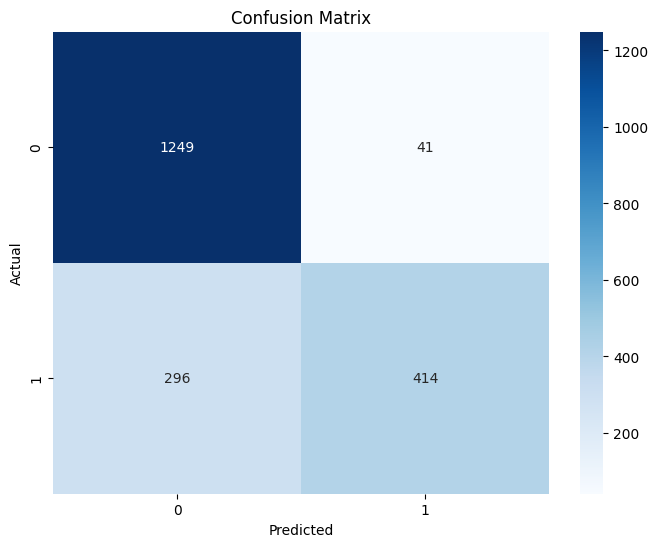

In [57]:
# prompt: plot confusion matrix

# Assuming 'conf_matrix' is already calculated as in the preceding code

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


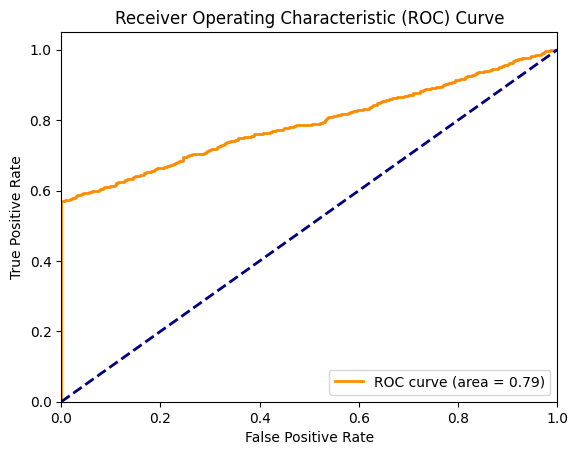

ROC AUC Score: 0.79053062561415
F1 Score: 0.7107296137339055
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1290
           1       0.91      0.58      0.71       710

    accuracy                           0.83      2000
   macro avg       0.86      0.78      0.80      2000
weighted avg       0.84      0.83      0.82      2000



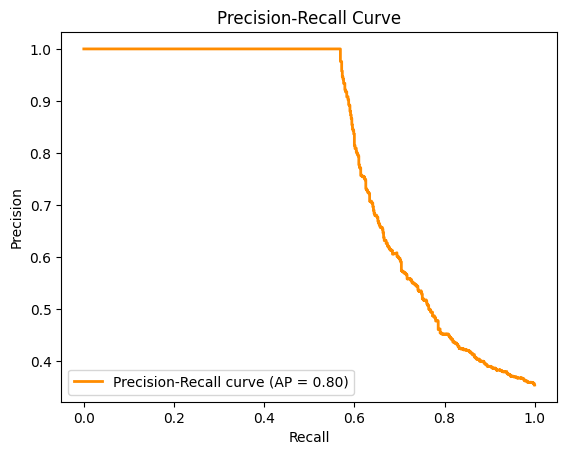

In [58]:

from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_recall_curve, average_precision_score

# ... (Your existing code) ...
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get the probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f'ROC AUC Score: {roc_auc}')

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Classification Report
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
